In [15]:
import pandas as pd
import numpy as np

featureset_path = "../dataset/mlcourse-dota2-win-prediction/train_features.csv"
targetset_path = "../dataset/mlcourse-dota2-win-prediction/train_targets.csv"

In [16]:
df = pd.read_csv(featureset_path)
target = pd.read_csv(targetset_path)

print(df.columns)
print(target.columns)

Index(['match_id_hash', 'game_time', 'game_mode', 'lobby_type',
       'objectives_len', 'chat_len', 'r1_hero_id', 'r1_kills', 'r1_deaths',
       'r1_assists',
       ...
       'd5_stuns', 'd5_creeps_stacked', 'd5_camps_stacked', 'd5_rune_pickups',
       'd5_firstblood_claimed', 'd5_teamfight_participation',
       'd5_towers_killed', 'd5_roshans_killed', 'd5_obs_placed',
       'd5_sen_placed'],
      dtype='object', length=246)
Index(['match_id_hash', 'game_time', 'radiant_win', 'duration',
       'time_remaining', 'next_roshan_team'],
      dtype='object')


In [17]:
column_to_drop = ["lobby_type","chat_len","game_mode"] # "match_id_hash","objectives_len"

filter = "(game_mode == 2 or game_mode == 22) and game_time > 0" # 2 standard ranked or 22 captain mode

df = df.query(filter)

df = df.drop(labels=column_to_drop,axis=1)

print(df.shape)

(32153, 243)


In [18]:
hero_id_labels = [s for s in df.columns if s.endswith('_hero_id')]

print(hero_id_labels)

hero_id_set = {i: set() for i in range(len(hero_id_labels))}

hero_id_set_tot = set()

for n,label in enumerate(hero_id_labels):
    for id in df[label]:
        hero_id_set[n].add(id)

for i in range(len(hero_id_labels)):
    print(f"{i}. {len(hero_id_set[i])}")
    hero_id_set_tot = hero_id_set_tot.union(hero_id_set[i])

print(len(hero_id_set_tot))


['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id']
0. 115
1. 115
2. 115
3. 115
4. 115
5. 115
6. 115
7. 115
8. 115
9. 115
115


In [19]:
for hero_id in hero_id_set_tot:
    df[f"r_{hero_id}"] = (
        (df["r1_hero_id"] == hero_id) | 
        (df["r2_hero_id"] == hero_id) |
        (df["r3_hero_id"] == hero_id) |
        (df["r4_hero_id"] == hero_id) |
        (df["r5_hero_id"] == hero_id)
    ).astype(int)
    df[f"d_{hero_id}"] = (
        (df["d1_hero_id"] == hero_id) | 
        (df["d2_hero_id"] == hero_id) |
        (df["d3_hero_id"] == hero_id) |
        (df["d4_hero_id"] == hero_id) |
        (df["d5_hero_id"] == hero_id)
    ).astype(int)

df = df.drop(labels=hero_id_labels,axis=1) #removed ri_hero_id and di_hero_id

print(df.shape)

print(df.iloc[0]["match_id_hash"])
print(df.iloc[0][df.iloc[0] == 1][-11:])

print("NaN Count: ",pd.isna(df).sum().sum())

print(df.index[:10])

df = df.copy()

C:\Users\green\AppData\Local\Temp\ipykernel_21320\268306986.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"d_{hero_id}"] = (
C:\Users\green\AppData\Local\Temp\ipykernel_21320\268306986.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"r_{hero_id}"] = (
C:\Users\green\AppData\Local\Temp\ipykernel_21320\268306986.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

(32153, 463)
a400b8f29dece5f4d266f49f1ae2e98a
d4_obs_placed    1
r_11             1
d_12             1
r_14             1
d_21             1
d_34             1
r_59             1
d_60             1
r_77             1
r_78             1
d_84             1
Name: 0, dtype: object
NaN Count:  0
Index([0, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')


In [20]:
tf_toreplace = ["r1_teamfight_participation", "r2_teamfight_participation","r3_teamfight_participation", "r4_teamfight_participation","r5_teamfight_participation","d1_teamfight_participation","d2_teamfight_participation","d3_teamfight_participation","d4_teamfight_participation",  "d5_teamfight_participation"]

for label in tf_toreplace:
    df.loc[df[label] > 1.0, label] = 1

a = df.loc[df["match_id_hash"] == "a400b8f29dece5f4d266f49f1ae2e98a"] #hash where nothing change = a400b8f29dece5f4d266f49f1ae2e98a ; hash where something change = 8e0ad8cbcf5a87c451e5e1e07596c443
print(a[tf_toreplace])

   r1_teamfight_participation  r2_teamfight_participation  \
0                         0.0                         0.0   

   r3_teamfight_participation  r4_teamfight_participation  \
0                         0.0                         0.0   

   r5_teamfight_participation  d1_teamfight_participation  \
0                         0.0                         1.0   

   d2_teamfight_participation  d3_teamfight_participation  \
0                         0.0                         0.0   

   d4_teamfight_participation  d5_teamfight_participation  
0                         1.0                         0.0  


In [21]:
import re
single_hero_labels = [s for s in df.columns if re.match(r"^[d|r]\d",s)]
print(single_hero_labels)

['r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold', 'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health', 'r1_max_mana', 'r1_level', 'r1_x', 'r1_y', 'r1_stuns', 'r1_creeps_stacked', 'r1_camps_stacked', 'r1_rune_pickups', 'r1_firstblood_claimed', 'r1_teamfight_participation', 'r1_towers_killed', 'r1_roshans_killed', 'r1_obs_placed', 'r1_sen_placed', 'r2_kills', 'r2_deaths', 'r2_assists', 'r2_denies', 'r2_gold', 'r2_lh', 'r2_xp', 'r2_health', 'r2_max_health', 'r2_max_mana', 'r2_level', 'r2_x', 'r2_y', 'r2_stuns', 'r2_creeps_stacked', 'r2_camps_stacked', 'r2_rune_pickups', 'r2_firstblood_claimed', 'r2_teamfight_participation', 'r2_towers_killed', 'r2_roshans_killed', 'r2_obs_placed', 'r2_sen_placed', 'r3_kills', 'r3_deaths', 'r3_assists', 'r3_denies', 'r3_gold', 'r3_lh', 'r3_xp', 'r3_health', 'r3_max_health', 'r3_max_mana', 'r3_level', 'r3_x', 'r3_y', 'r3_stuns', 'r3_creeps_stacked', 'r3_camps_stacked', 'r3_rune_pickups', 'r3_firstblood_claimed', 'r3_teamfight_participation', 'r3_to

In [22]:
target = target.loc[df.index]
print(target.shape)
df = df.drop('match_id_hash',axis=1)

(32153, 6)


In [23]:
win = target["radiant_win"].astype(int)
X = np.array(df.values)
Y = np.array(win)

print(X.shape)
print(Y.shape)

(32153, 462)
(32153,)


In [24]:
from sklearn.model_selection import train_test_split

np.random.seed(seed=10)

X_train,X_test,Y_train,Y_test = train_test_split(df,win,test_size=0.2)

In [25]:
from sklearn.ensemble import RandomForestClassifier

#feature_selector = RandomForestClassifier(max_depth=10)
feature_selector = RandomForestClassifier(max_depth=50, n_estimators=200)

feature_selector.fit(X_train,Y_train)

RandomForestClassifier(max_depth=50, n_estimators=200)

In [26]:
from sklearn.metrics import roc_auc_score, accuracy_score

Y_pred = feature_selector.predict(X_test)

acc = accuracy_score(Y_test,Y_pred)
auc = roc_auc_score(Y_test,Y_pred)

print("Accouracy ",acc)
print("Auc",auc)

feature_importance = {
    name: value 
    for name,value in zip(feature_selector.feature_names_in_,feature_selector.feature_importances_)
}

print(feature_importance)

feature_importance = dict(reversed(sorted(feature_importance.items(), key=lambda item: item[1])))
print(feature_importance)
feature_names = list(feature_importance.keys())[:10]
print(list(feature_importance.keys())[-10:])
print(feature_names)
print(list(feature_importance.keys()))
print(feature_importance["d_58"])
print(feature_importance["d_68"])
print(feature_importance["r_32"])
print(feature_importance["d_32"])
print(feature_importance["r2_y"])
print(feature_importance["objectives_len"])

Accouracy  0.7062665215363085
Auc 0.702026369885723
{'game_time': 0.004654120741603062, 'objectives_len': 0.002823337068456266, 'r1_kills': 0.00347498097733561, 'r1_deaths': 0.005229583604530463, 'r1_assists': 0.0038871475950258824, 'r1_denies': 0.003960931743982718, 'r1_gold': 0.006462858391906488, 'r1_lh': 0.004835228077100924, 'r1_xp': 0.005886032889555476, 'r1_health': 0.005657363338337944, 'r1_max_health': 0.005178224116475264, 'r1_max_mana': 0.00539971138936835, 'r1_level': 0.0027884358920607292, 'r1_x': 0.010635501802834119, 'r1_y': 0.011987026708044385, 'r1_stuns': 0.0033540580015328143, 'r1_creeps_stacked': 0.0010997734202631247, 'r1_camps_stacked': 0.0007735389018206215, 'r1_rune_pickups': 0.003478794234780607, 'r1_firstblood_claimed': 0.0004054078337634894, 'r1_teamfight_participation': 0.004230822650508912, 'r1_towers_killed': 0.0012529551565886538, 'r1_roshans_killed': 0.00015786839763776267, 'r1_obs_placed': 0.0016202018705572534, 'r1_sen_placed': 0.001260295208705773, 'r

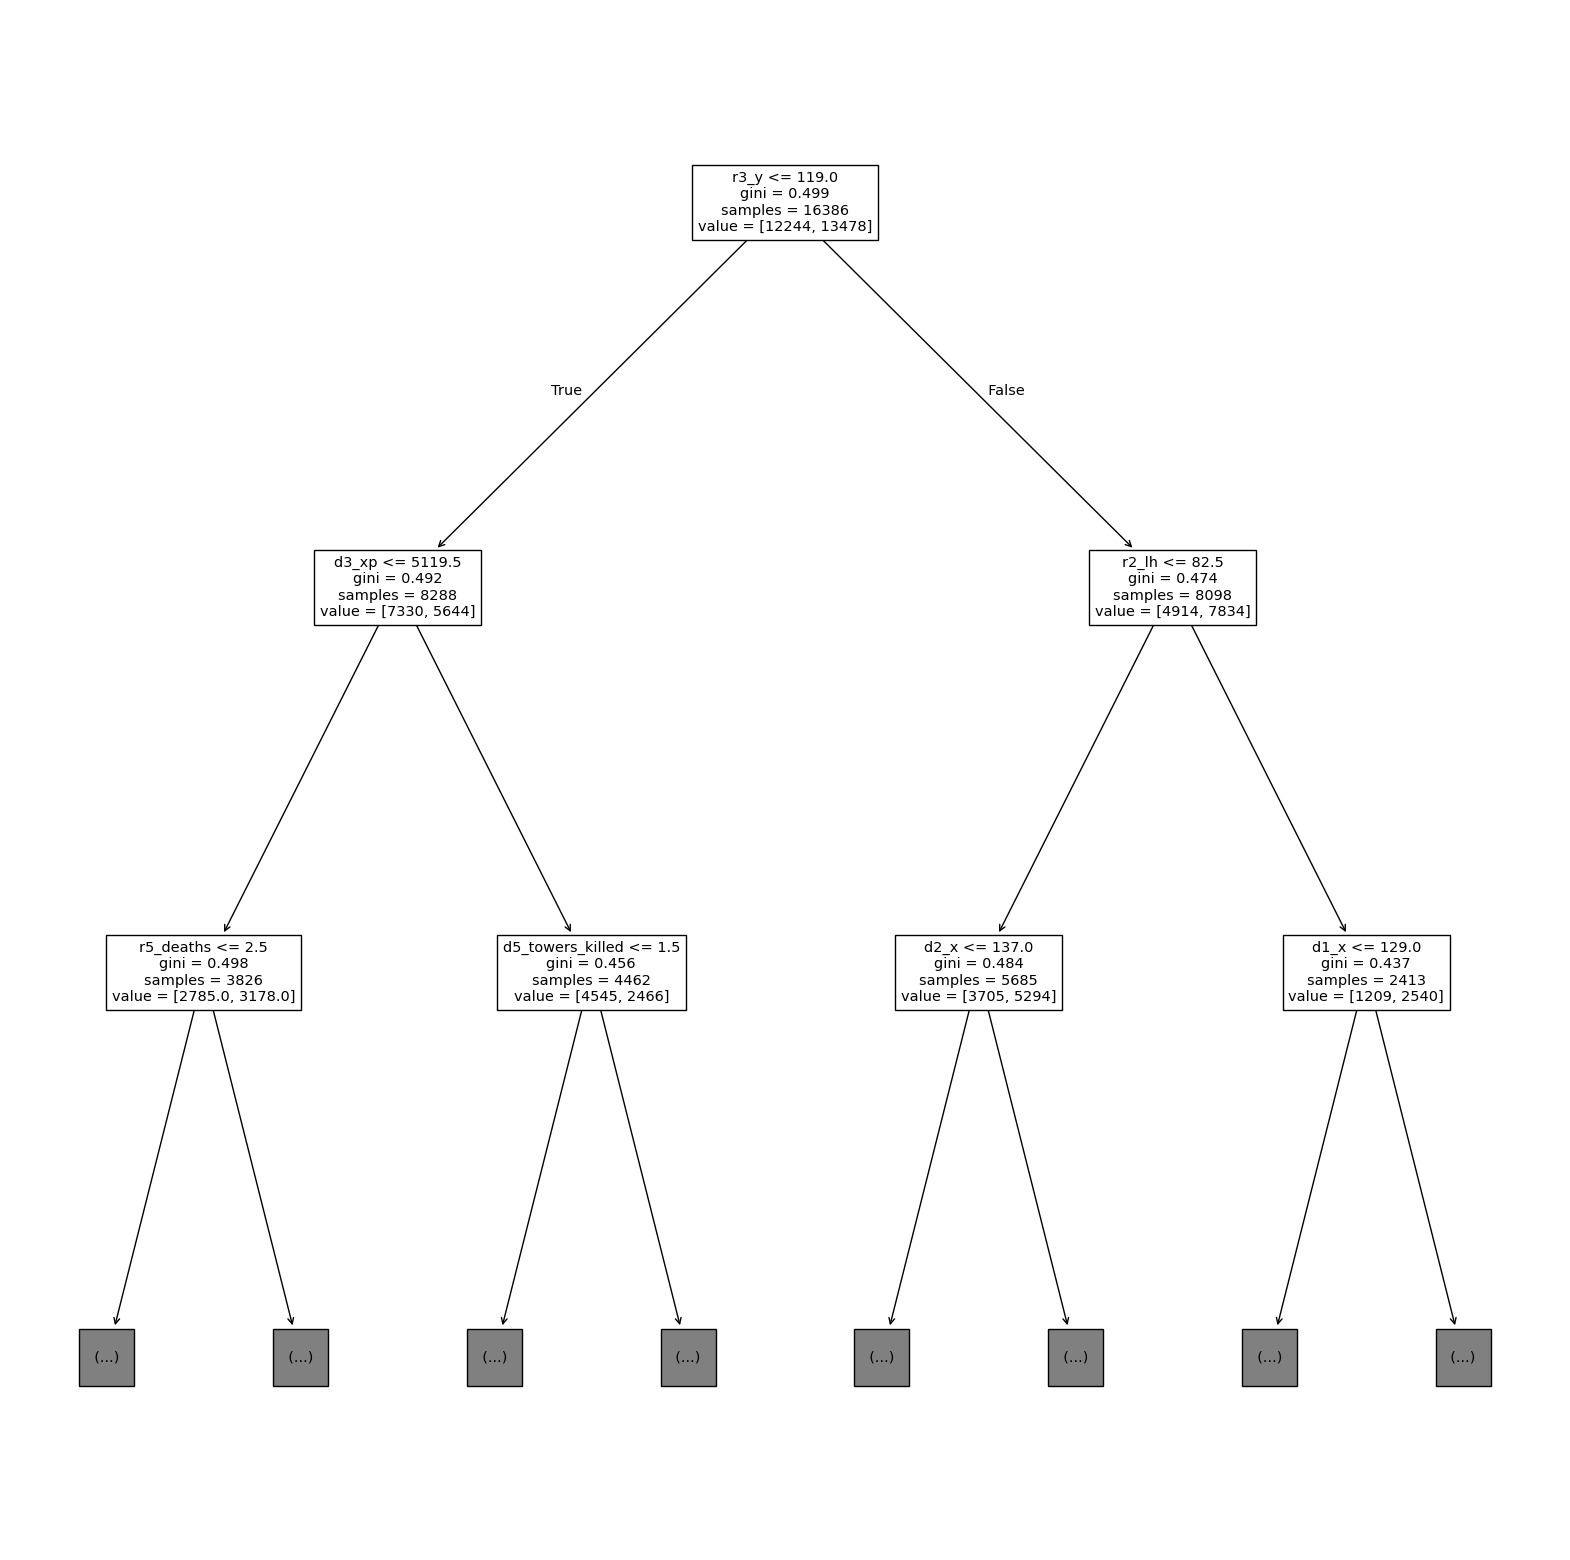

In [27]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree = feature_selector.estimators_[3]

plt.figure(figsize=(20,20))
plot_tree(tree,max_depth=2,feature_names=df.columns)
plt.show()